In [ ]:
!nvidia-smi

Thu Jun 22 07:32:50 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
pip install -q autodistill autodistill-grounded-sam autodistill-yolov8 supervision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.4/82.4 kB 9.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.0/527.0 kB 49.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.7/206.7 kB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 114.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.3/250.3 kB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 93.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 92.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 126.0 MB/s eta 0:00:00


In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [ ]:
!mkdir {HOME}/images

In [ ]:
IMAGE_DIR_PATH = f"{HOME}/images"
SAMPLE_SIZE = 16
SAMPLE_GRID_SIZE = (4, 4)
SAMPLE_PLOT_SIZE = (16, 16)

In [ ]:
import cv2,supervision as sv

In [ ]:
image_paths = sv.list_files_with_extensions(
    directory=IMAGE_DIR_PATH,
    extensions=["png", "jpg", "jpg"])

print('image count:', len(image_paths))

image count: 166


In [ ]:
titles = [
    image_path.stem
    for image_path
    in image_paths[:SAMPLE_SIZE]]
images = [
    cv2.imread(str(image_path))
    for image_path
    in image_paths[:SAMPLE_SIZE]]

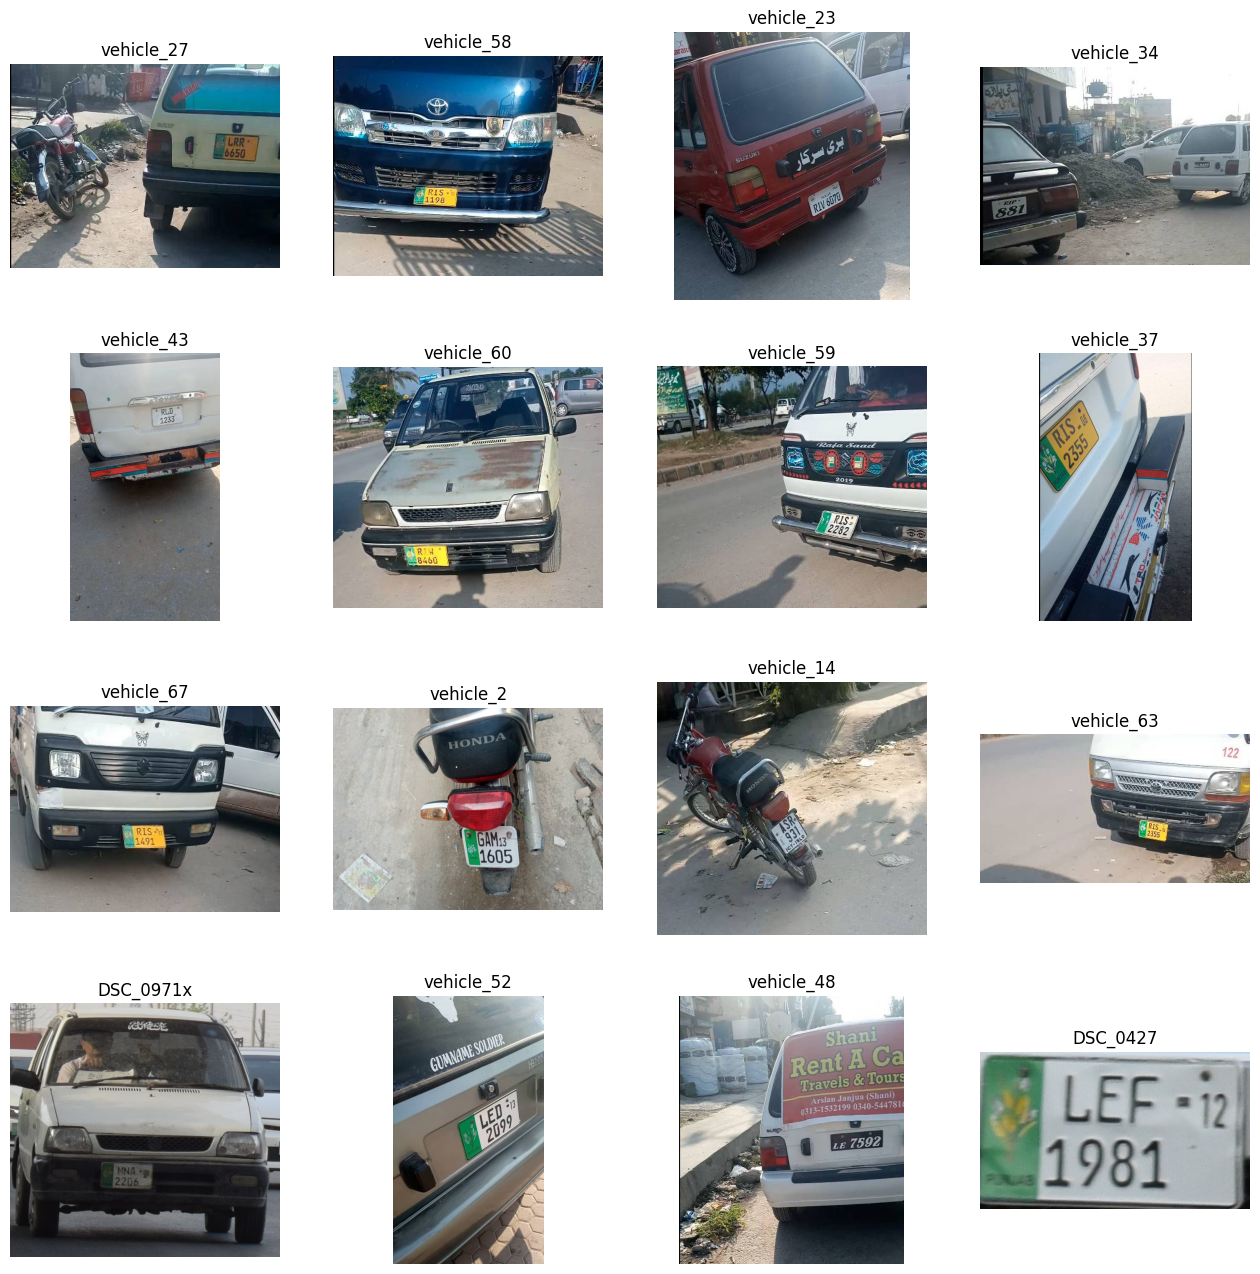

In [ ]:
sv.plot_images_grid(images=images, titles=titles, grid_size=SAMPLE_GRID_SIZE, size=SAMPLE_PLOT_SIZE)

In [ ]:
from autodistill.detection import CaptionOntology

ontology=CaptionOntology({
    "licence plate": "plate",
})

In [ ]:
!mkdir {HOME}/dataset

mkdir: cannot create directory ‘/content/dataset’: File exists


In [ ]:
DATASET_DIR_PATH = f"{HOME}/dataset"
DATASET_DIR_PATH

'/content/dataset'

In [ ]:
from autodistill_grounded_sam import GroundedSAM

base_model = GroundedSAM(ontology=ontology)
dataset = base_model.label(
    input_folder=IMAGE_DIR_PATH,
    extension=".png",
    output_folder=DATASET_DIR_PATH)

trying to load grounding dino directly
final text_encoder_type: bert-base-uncased


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Labeling images: 0it [00:00, ?it/s]

Labeled dataset created - ready for distillation.


In [ ]:
ANNOTATIONS_DIRECTORY_PATH = f"{HOME}/dataset/train/labels"
IMAGES_DIRECTORY_PATH = f"{HOME}/dataset/train/images"
DATA_YAML_PATH = f"{HOME}/dataset/data.yaml"

In [ ]:
dataset = sv.DetectionDataset.from_yolo(
    images_directory_path=IMAGES_DIRECTORY_PATH,
    annotations_directory_path=ANNOTATIONS_DIRECTORY_PATH,
    data_yaml_path=DATA_YAML_PATH)

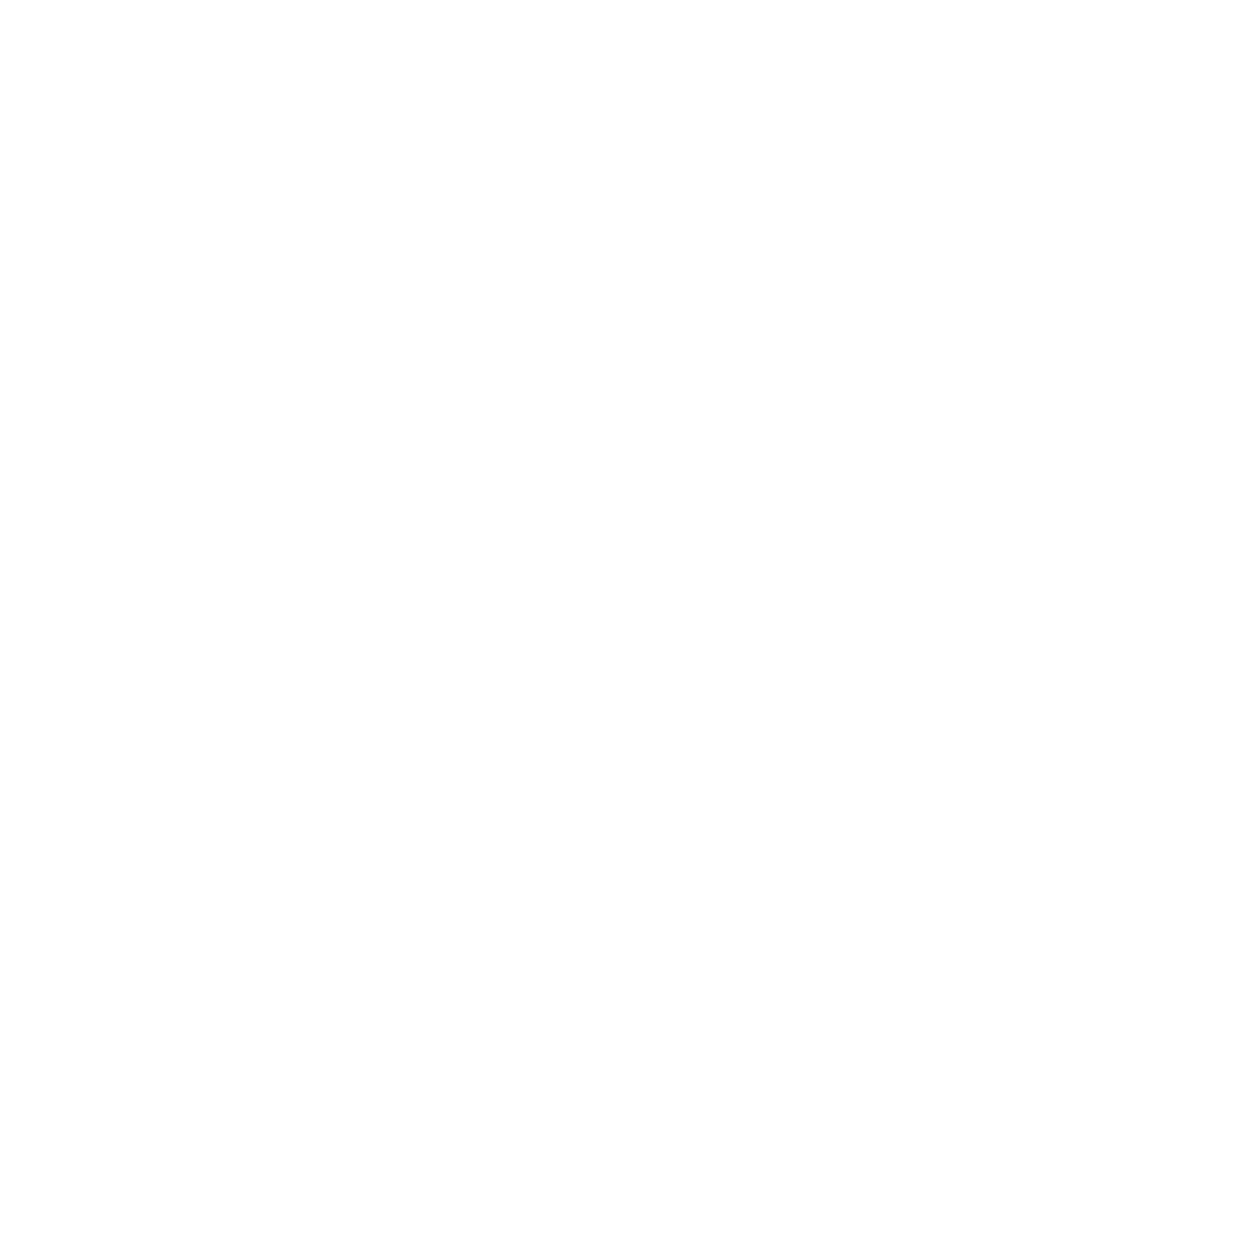

In [ ]:
image_names = list(dataset.images.keys())[:SAMPLE_SIZE]

mask_annotator = sv.MaskAnnotator()
box_annotator = sv.BoxAnnotator()

images = []
for image_name in image_names:
    image = dataset.images[image_name]
    annotations = dataset.annotations[image_name]
    labels = [
        dataset.classes[class_id]
        for class_id
        in annotations.class_id]
    annotates_image = mask_annotator.annotate(
        scene=image.copy(),
        detections=annotations)
    annotates_image = box_annotator.annotate(
        scene=annotates_image,
        detections=annotations,
        labels=labels)
    images.append(annotates_image)

sv.plot_images_grid(
    images=images,
    titles=image_names,
    grid_size=SAMPLE_GRID_SIZE,
    size=SAMPLE_PLOT_SIZE)

In [ ]:
!nvidia-smi

Thu Jun 22 09:07:05 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8    12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import os
home = os.getcwd()
home


'/content'

In [ ]:
!pip install ultralytics
from IPython import display
display.clear_output()
!yolo mode = checks

WARNING ⚠️ 'yolo mode=checks' is deprecated. Use 'yolo checks' instead.
Ultralytics YOLOv8.0.121 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 24.1/78.2 GB disk)


In [ ]:
from ultralytics import YOLO
from IPython.display import display,Image

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="S8fMgPvlPiRbJvTmRrKW")
project = rf.workspace("yolov8practice").project("pak_number_plate_detection")
dataset = project.version(1).download("yolov8")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 9.5 MB/s eta 0:00:00
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9657 sha256=c3208f81acf001dd61247e26cb4278e2a8c952ea641490cc27e980e8a777f231
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.0.9
    Uninstalling pyparsing-3.0.9:
      Successfully uninstalled pyparsing-3.0.9
  Attempting uninstal

loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics<=8.0.20 is required but found version=8.0.121, to fix: `pip install ultralytics<=8.0.20`


Extracting Dataset Version Zip to pak_number_plate_detection-1 in yolov8:: 100%|██████████| 506/506 [00:00<00:00, 1975.71it/s]


In [ ]:
%cd {home}

!yolo task=detect mode=train model=yolov8s.pt data={dataset.location}/data.yaml epochs=25 imgsz=800 plots=True

/content
Ultralytics YOLOv8.0.121 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/pak_number_plate_detection-1/data.yaml, epochs=25, patience=50, batch=16, imgsz=800, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=0, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optim

In [ ]:
!ls {home}/runs/detect/train2/

args.yaml					    R_curve.png
confusion_matrix_normalized.png			    results.csv
confusion_matrix.png				    results.png
events.out.tfevents.1687425124.c970bbee519e.3792.0  train_batch0.jpg
F1_curve.png					    train_batch1.jpg
labels_correlogram.jpg				    train_batch2.jpg
labels.jpg					    val_batch0_labels.jpg
P_curve.png					    val_batch0_pred.jpg
PR_curve.png					    weights


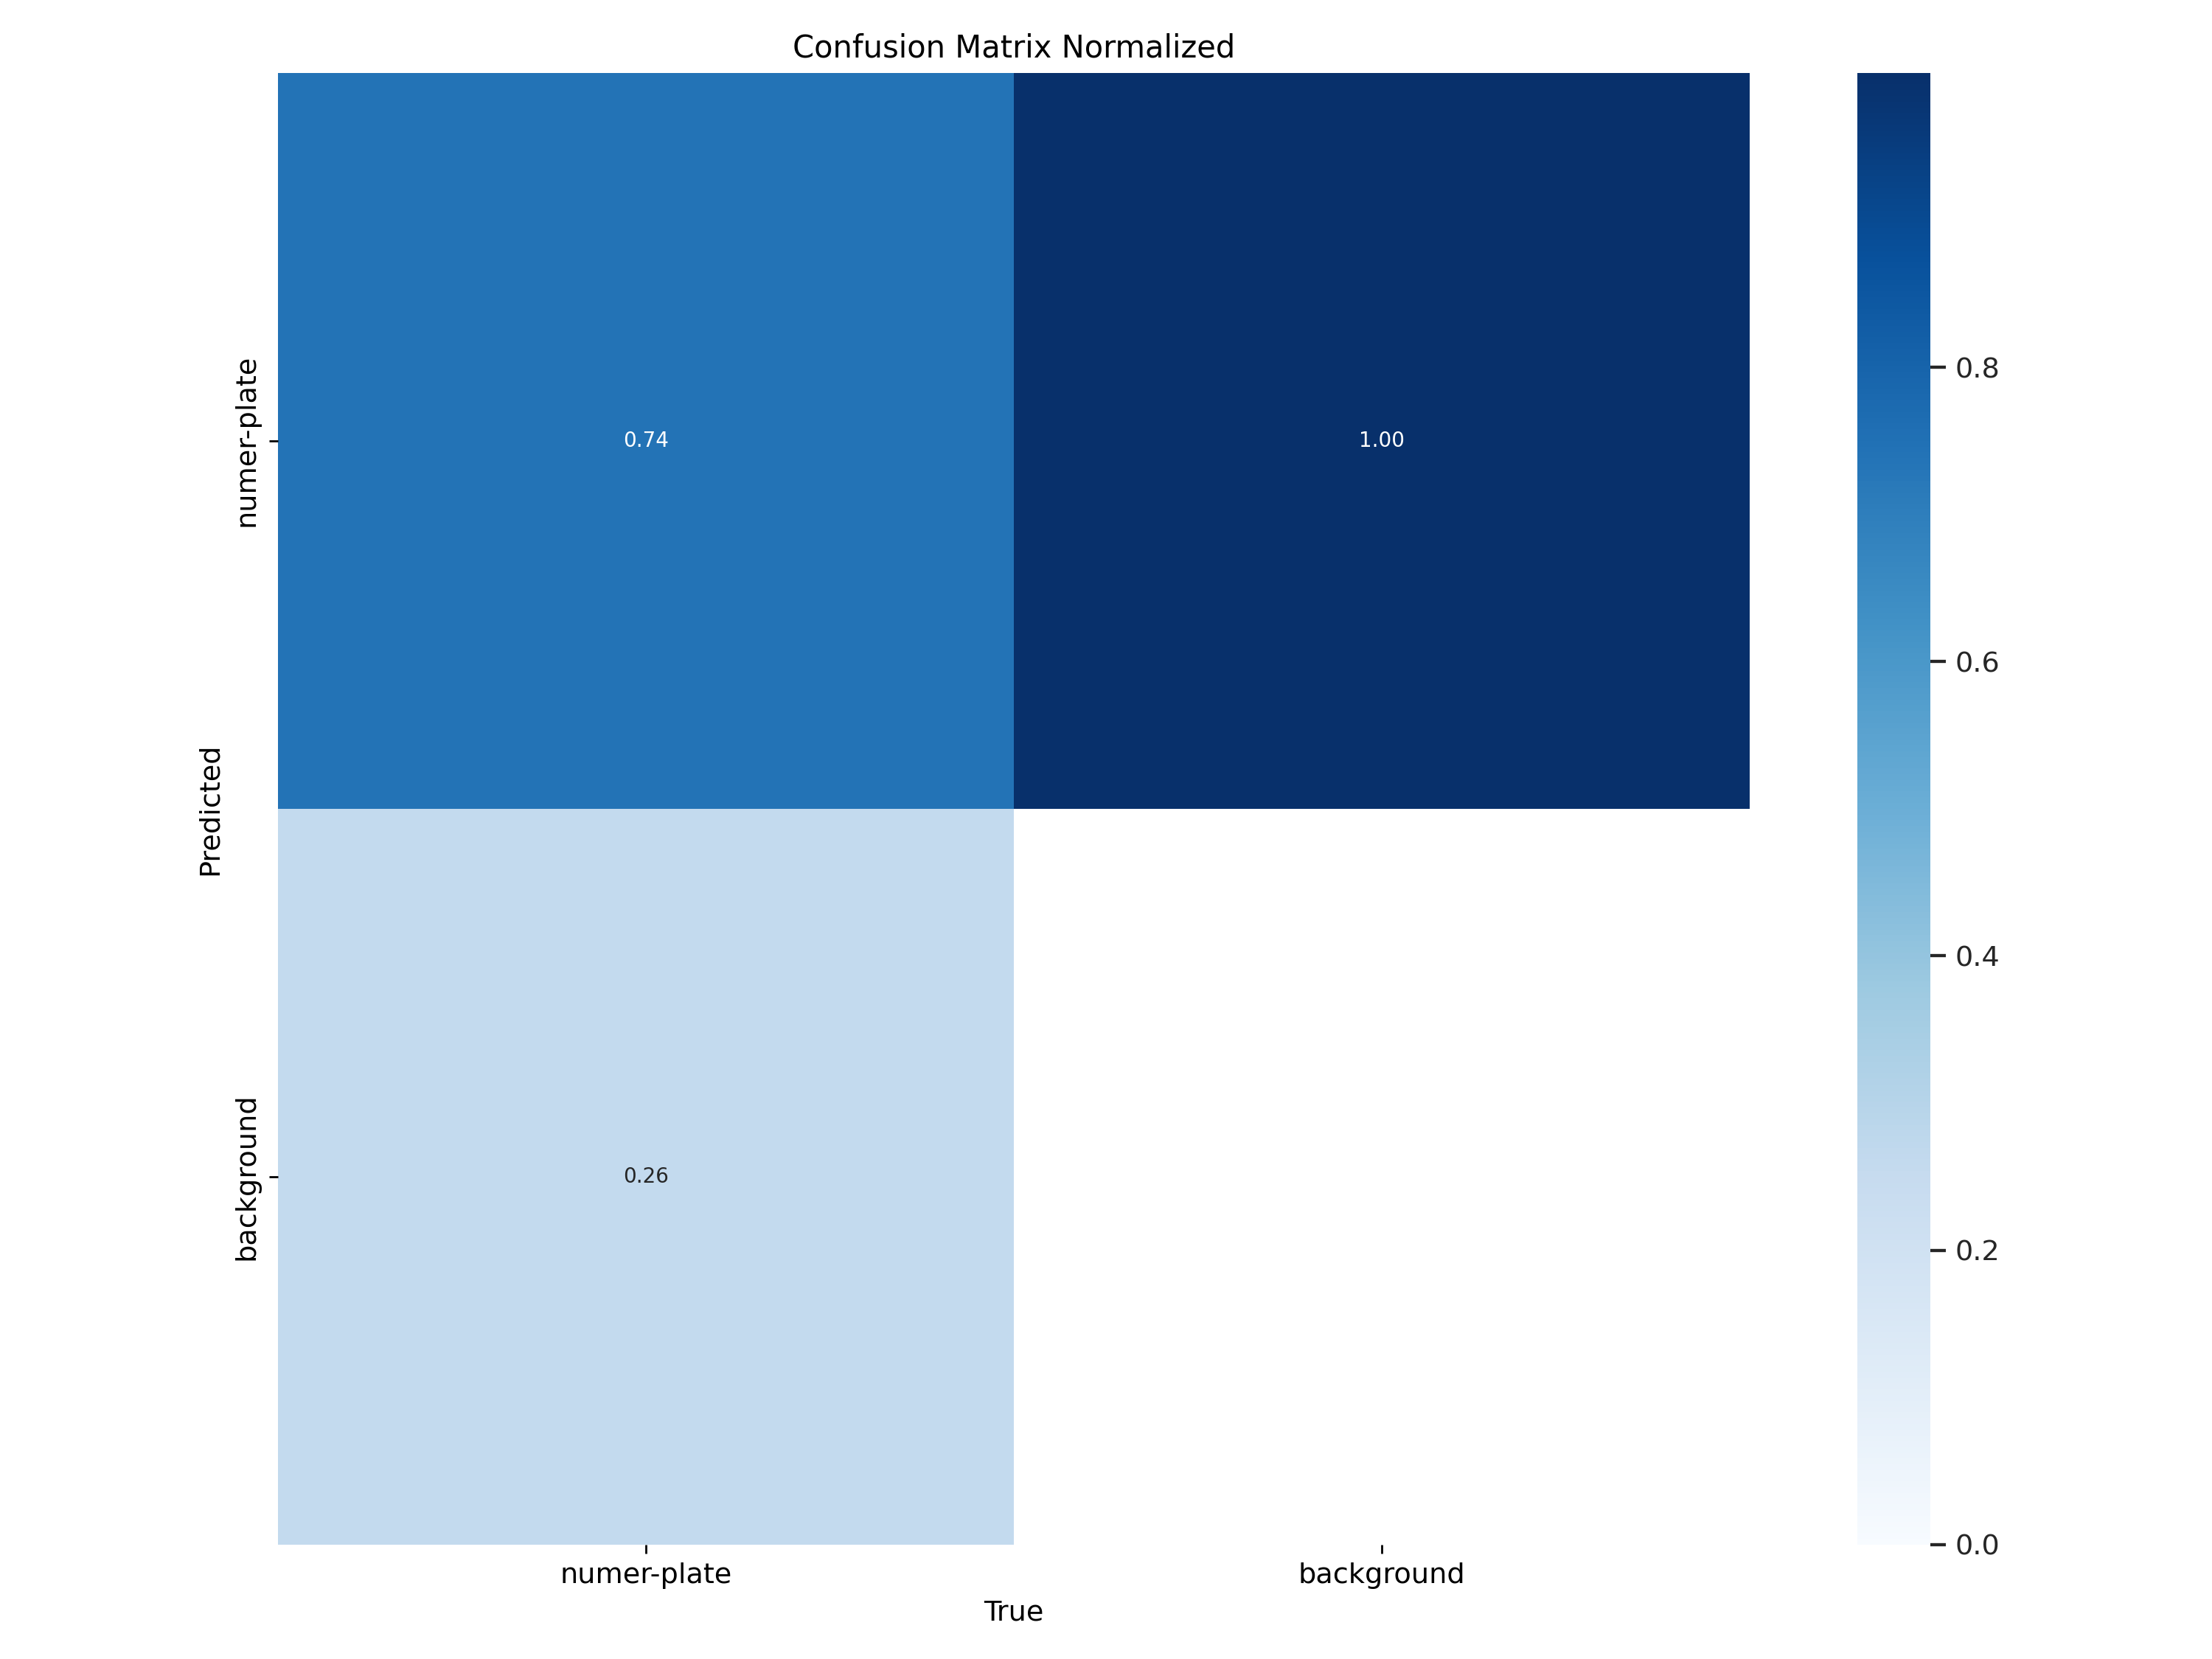

In [ ]:
Image(filename=f'/content/runs/detect/train2/confusion_matrix_normalized.png',width=800)

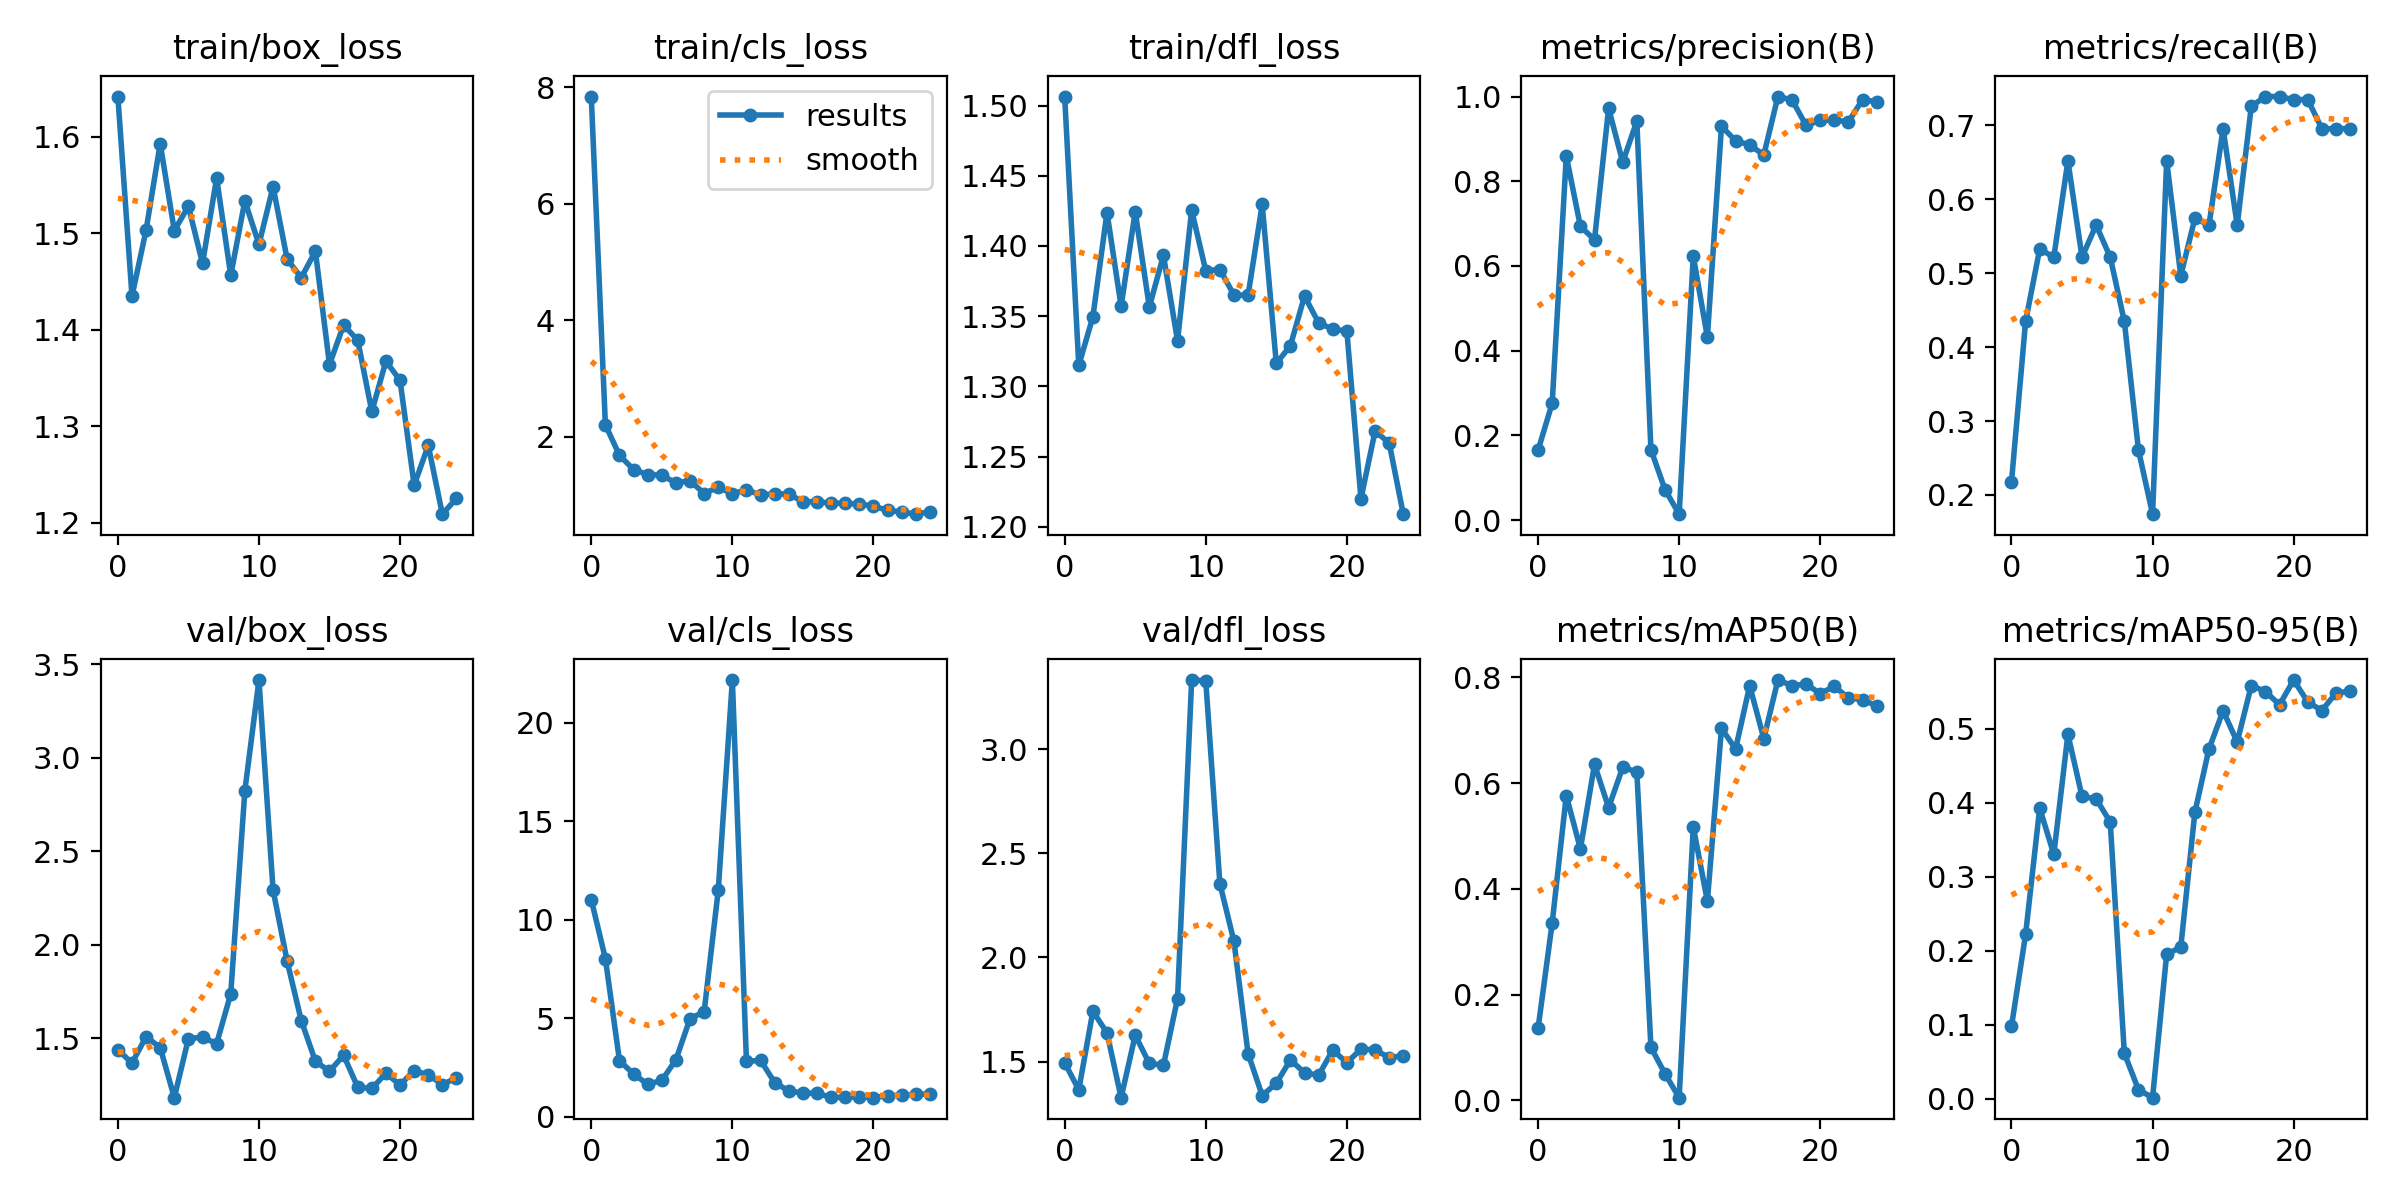

In [ ]:
Image(filename=f'/content/runs/detect/train2/results.png',width=800)

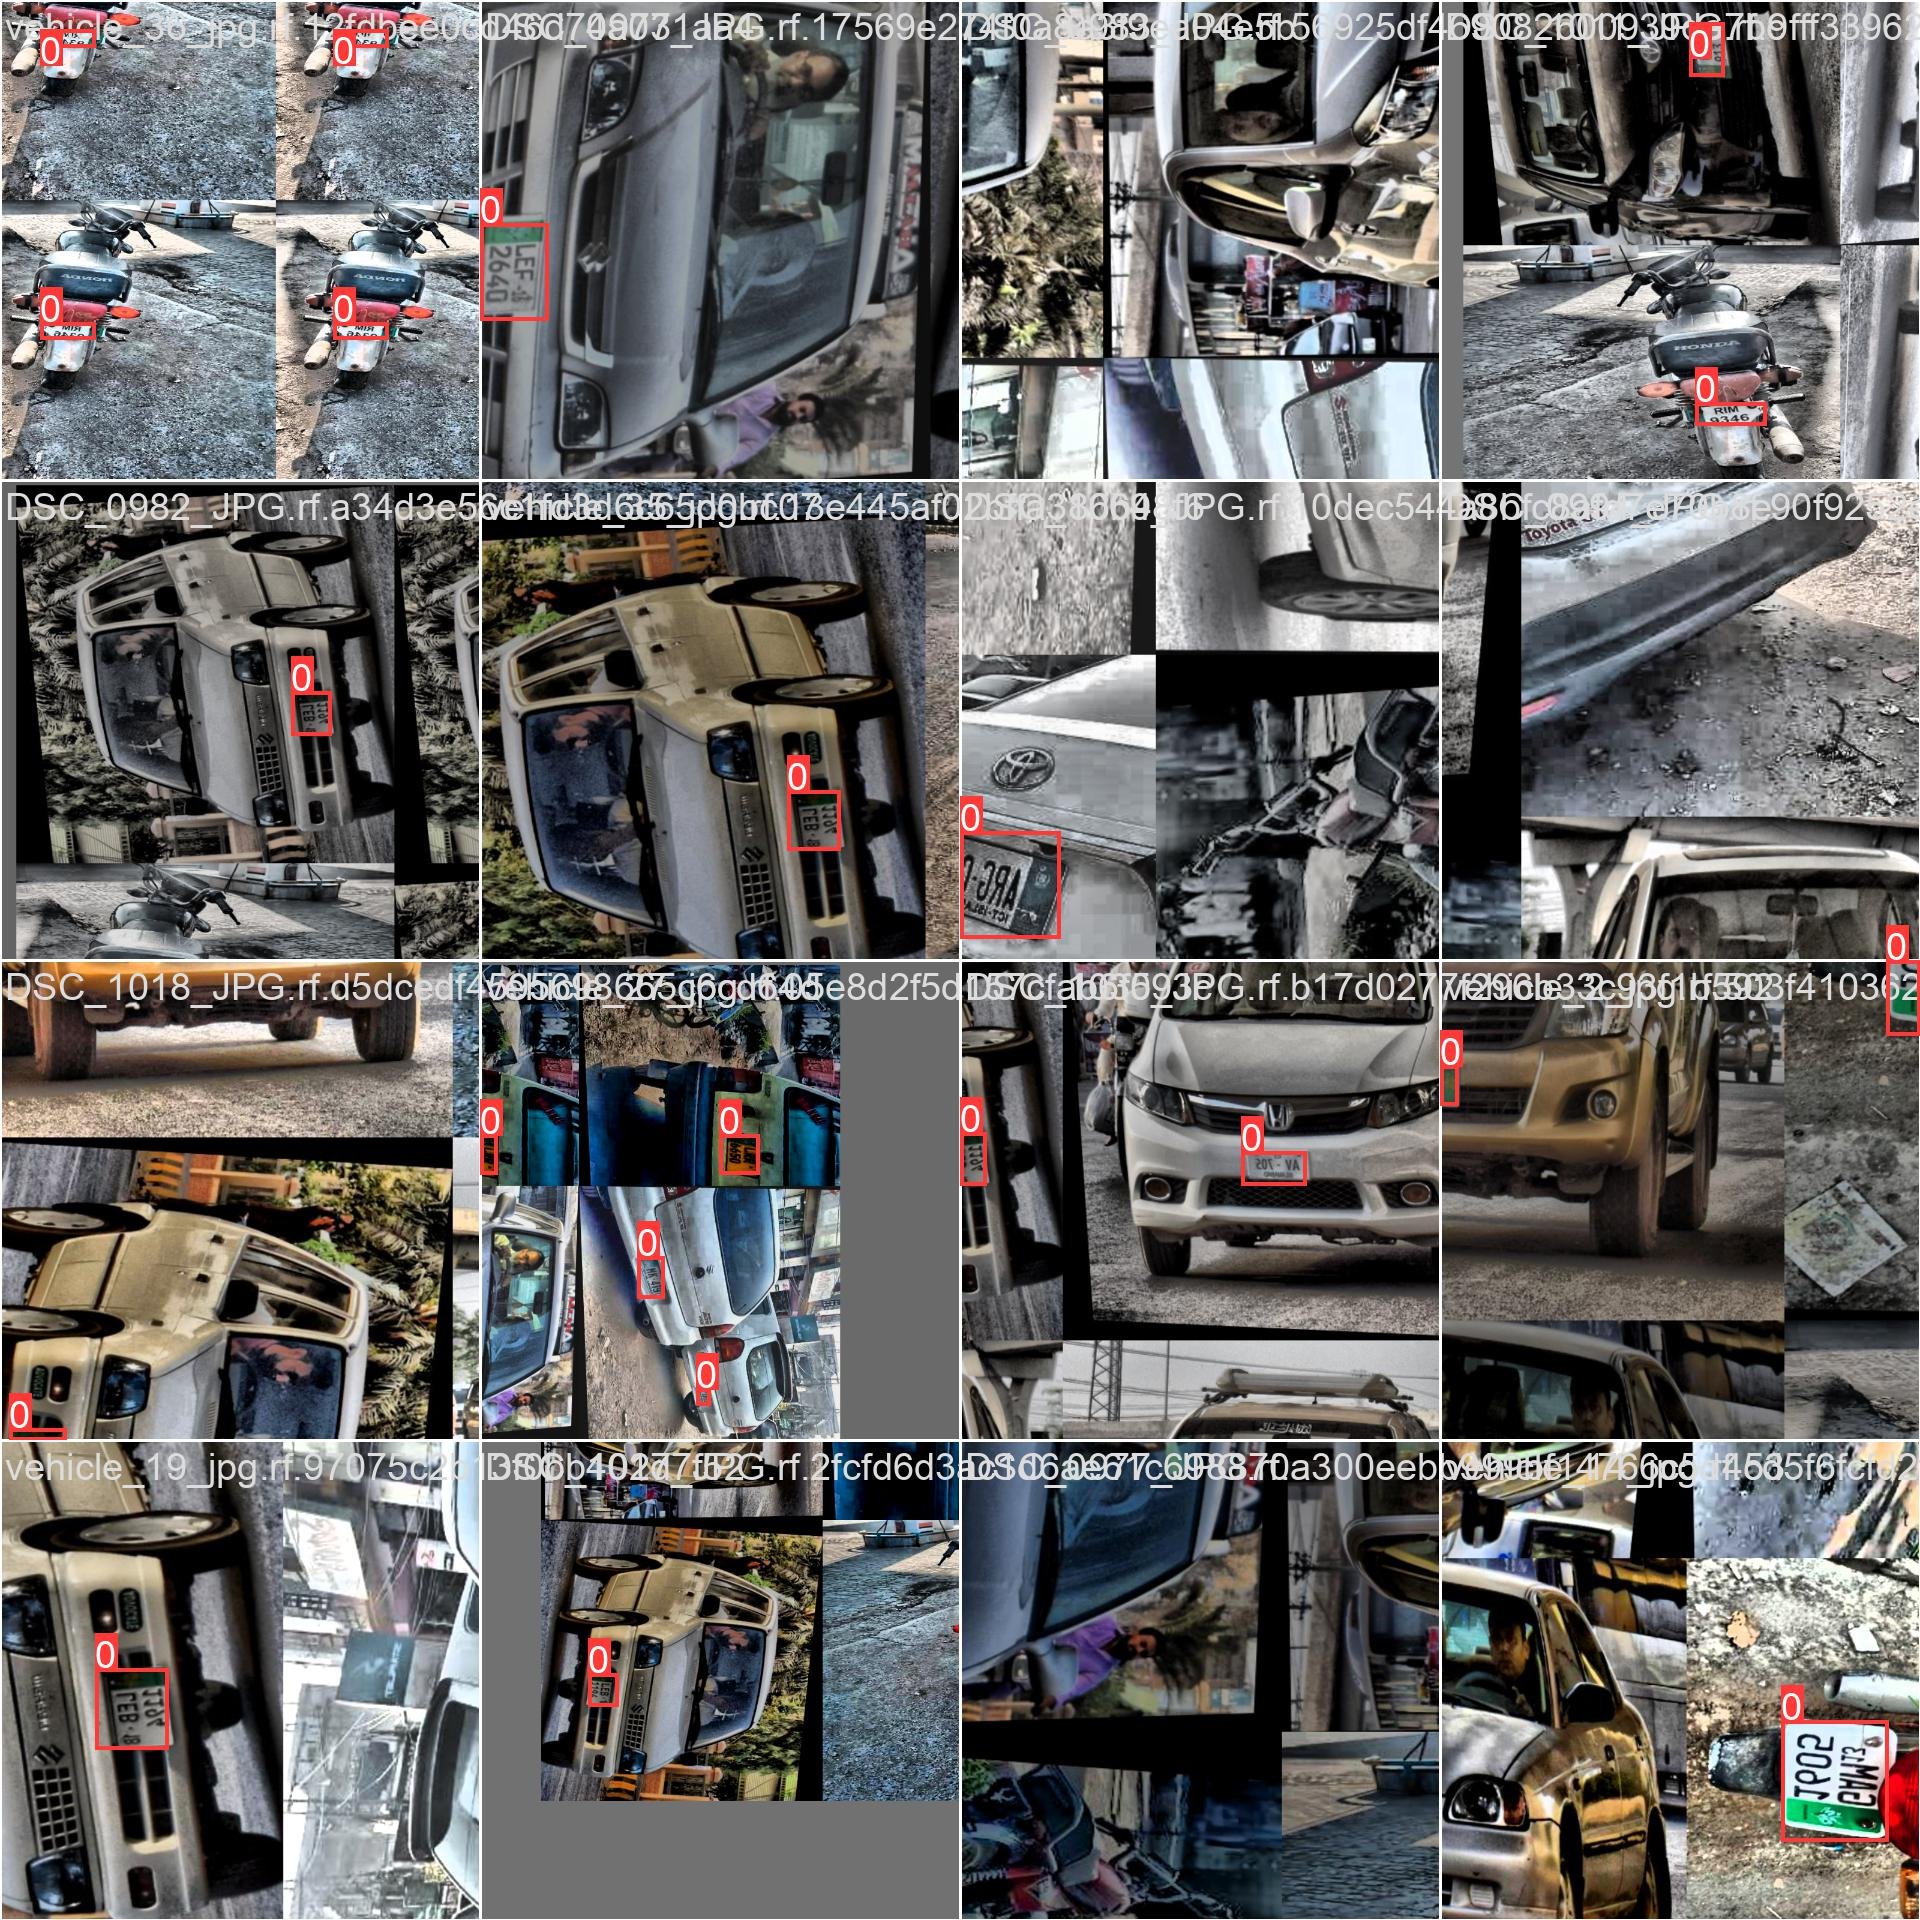

In [ ]:
Image(filename=f'/content/runs/detect/train2/train_batch0.jpg',width=800)

In [ ]:
!yolo task=detect \
mode=val \
model={home}/runs/detect/train2/weights/best.pt \
data={dataset.location}/data.yaml

Ultralytics YOLOv8.0.121 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11125971 parameters, 0 gradients
val: Scanning /content/pak_number_plate_detection-1/valid/labels.cache... 20 images, 0 backgrounds, 0 corrupt: 100% 20/20 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 2/2 [00:00<00:00,  2.27it/s]
                   all         20         23      0.944      0.735       0.77      0.569
Speed: 7.0ms preprocess, 22.6ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs/detect/val


In [ ]:
!yolo task=detect \
mode=predict \
model={home}/runs/detect/train2/weights/best.pt \
conf=0.25 \
source={dataset.location}/test/images

Ultralytics YOLOv8.0.121 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11125971 parameters, 0 gradients

image 1/11 /content/pak_number_plate_detection-1/test/images/DSC_0971x_jpg.rf.9a0fa795138b285954389096f625a21c.jpg: 800x800 1 numer-plate, 24.8ms
image 2/11 /content/pak_number_plate_detection-1/test/images/DSC_0985_JPG.rf.5ec491a0064cce576b99c5b9f1345ec2.jpg: 800x800 1 numer-plate, 24.6ms
image 3/11 /content/pak_number_plate_detection-1/test/images/DSC_0992_JPG.rf.ce523a49699e03312ed57ffebb1af688.jpg: 800x800 1 numer-plate, 24.6ms
image 4/11 /content/pak_number_plate_detection-1/test/images/DSC_1010_JPG.rf.657670fd4a24099415d5fe849e738273.jpg: 800x800 1 numer-plate, 24.6ms
image 5/11 /content/pak_number_plate_detection-1/test/images/DSC_1026_JPG.rf.8115c71c73b9d3eba2e862634baba8f1.jpg: 800x800 1 numer-plate, 20.4ms
image 6/11 /content/pak_number_plate_detection-1/test/images/DSC_1035_JPG.rf.e492217d81b631996782bf2fa4d2955f.jpg: 80

In [ ]:
import glob
for img in glob.glob('/content/runs/detect/predict/*.jpg'):
  display(Image(filename=img,width=600))
  print('\n')

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import supervision as sv

In [58]:
from ultralytics import YOLO
from ultralytics.yolo.utils.patches import imread
model=YOLO(f'{home}/runs/detect/train2/weights/best.pt',task='detect')
model.conf = 0.5


In [76]:
import glob

In [77]:
# extract video frame

#generator =
#iterator = iter(generator)

for frame in glob.glob('/content/runs/detect/predict/*.jpg'):
#frame = imread(f'/content/pak_number_plate_detection-1/test/images/DSC_0971x_jpg.rf.9a0fa795138b285954389096f625a21c.jpg')


  # detect
  results = model.predict(frame, imgsz=1280)[0]
  detections = sv.Detections(
          xyxy= results.boxes.xyxy.cpu().numpy(),
          confidence= results.boxes.conf.cpu().numpy(),
          class_id= results.boxes.cls.cpu().numpy().astype(int),
      )

  detections = detections[detections.confidence>=0.5]
  labels = [
          f'plate {conf:0.2f}'
          for _,_,conf,_,_ in detections
      ]

  # annotate
  box_annotator = sv.BoxAnnotator(thickness=4, text_thickness=1,text_scale=1,text_color=sv.Color.white)
  frame = box_annotator.annotate(scene=frame, detections=detections,labels=labels)

  %matplotlib inline
  sv.plot_image(frame, (16, 16))


image 1/1 /content/runs/detect/predict/DSC_1057_JPG.rf.a8a8a3b1c072f3612933a225c3c69f7b.jpg: 1280x1280 2 numer-plates, 47.8ms
Speed: 10.3ms preprocess, 47.8ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 1280)


error: ignored

In [63]:
results.boxes.conf

tensor([0.6933, 0.3452], device='cuda:0')